# Introduction to Bigraphs

Bigraphs were invented by Robin Milner as an extension/generalization of previous process calculi (some of which he invented as well). A [process calculus](https://en.wikipedia.org/wiki/Process_calculus) is a way to formally model concurrent and distributed systems, including communication/interactions/synchronizations, along with a set of algebraic laws to reason about them. 

![bigraph](img/first-bigraph.png)

## space

The structure of a bigraph is defined as two superimposed graphs over a single set of nodes 
- *place* graph (forest) which is modeled as a tree
- *link* graph (hypergraph) which is a set of hyperedges 

![bare bigraph](img/bare-bigraph.png)

### place graph

The place graph represents the relative _location_ of each node (in terms of containment).

![forest](img/bigraph-and-forest.png)

### link graph

The link graph represents communication across place boundaries, ie common signals that all linked nodes share.  

![hypergraph](img/bigraph-and-hypergraph.png)

![anatomy](img/anatomy-of-bigraphs.png)

## motion

The "motion" of a bigraph is accomplished by _reaction rules_, which specify a `redex` showing a bigraph to match and `reactum` that shows the bigraph to replace it by. 

Here is an example bigraph (showing the system in a "locked" state): ![locked](img/reaction-locked.png)

### redex

When we take that bigraph and match it with this **redex**

![redex](img/reaction-redex.png)

### reactum

and substitute with this **reactum**

![reactum](img/reaction-reactum.png)

### transition

we end up with this result (the key has been "unlocked"):

![unlocked](img/reaction-unlocked.png)

### full reaction

Here is the full reaction from locked to unlocked state:

![reaction](img/reaction-example.png)

In [1]:
from bigraph.bigraph import Bigraph, Control, Node, Edge, Parallel, Merge, Big, InGroup, Condition, Reaction, Range, Assign, Init, Param, RuleGroup, Rules, Preds, System, BigraphicalReactiveSystem, visualize, visualize_transition, react
from bigraph.parse import bigraph

## operations

You can build complex bigraphs out of simpler bigraphs using the basic operations:
* A.B - *nest* (nesting B inside A)
* A | B - *merge* (side by side, but in the same region)
* A || B - *parallel* (side by side, different regions)
* A{b} - *link* (A is linked to edge b)
* A(b) - *parameterize* (A has parameter b)

## python API

You can parse bigraphs from strings into python objects, and you can also build up bigraphs programmatically using the python API. The basic operations are available:

### nest

In [2]:
A = bigraph('A')
B = bigraph('B')
A.nest(B)

A.B

In [3]:
visualize(A)

A.B

### merge

In [4]:
A = bigraph('A')
B = bigraph('B')
merge = Merge([A, B])
merge

A | B

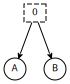

A | B

In [5]:
visualize(merge)

### parallel

In [6]:
A = bigraph('A')
B = bigraph('B')
Parallel([A, B])

A || B

### link

In [7]:
A = bigraph('A')
b = Edge('b')
A.link(b)

A{b}

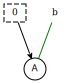

A{b}

In [8]:
visualize(A)

## parsing

The notation we have been using for bigraphs is Milner's original formalized into a language named `.big`, as implemented by the [Glasgow Bigraph Team](https://uog-bigraph.bitbucket.io/index.html). We are using their engine to run simulations, but we have our own parser for `.big` files implemented as a [Parsing Expression Grammar](https://en.wikipedia.org/wiki/Parsing_expression_grammar) that converts strings into python bigraph objects. 

To access the `.big` parser, use the `bigraph` function:

In [9]:
parsed = bigraph('A.(B | C{m, n})')
parsed

A.(B | C{m,n})

The python bigraph objects are rendered by default, which mirrors the original form we parsed. 

We can also build this bigraph programmatically.

In [10]:
A = bigraph('A')
B = bigraph('B')
C = bigraph('C')
A, B, C

(A, B, C)

In [11]:
C.link('m')
C.link('n')
C

C{m,n}

In [12]:
merge = B.merge(C)
merge

B | C{m,n}

In [13]:
A.nest(merge)
A

A.(B | C{m,n})

Let's visualize this bigraph:

A.(B | C{m,n})


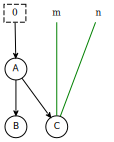

A.(B | C{m,n})

In [14]:
print(A)
visualize(A)

TODO: show rendered results from running the system

TODO: render bigraphs in a nested way

## controls

Controls are a way to label nodes, giving it a kind of "type" which declares:
- **symbol** - the label given by this control
- **arity** - how many ports it has (where edges can connect)
- **fun** - any parameters nodes of this control may have
- **atomic** - whether it can have subnodes or not

Here is an example of a control with an arity of 2:

In [15]:
D1 = bigraph('ctrl D = 2')
D1.symbol, D1.arity

('D', 2)

Here is another control with named parameters:

In [16]:
C = bigraph('fun ctrl Compartment(volume, state) = 1')
C.symbol, C.arity, C.fun

('Compartment', 1, ('volume', 'state'))

### nodes and controls

Controls give us a more principled way to create nodes, and provide a way to structure our systems and guide reactions to target specific elements.

In [17]:
C1 = Node(control=C, params=(0.3, "stable"), ports=('atp',))
C2 = Node(control=C, params=(11.1111, "active"), ports=('chromosome',))
C1, C2

(Compartment(0.3,stable){atp}, Compartment(11.1111,active){chromosome})

We can even assign parameters this way

In [18]:
C1.assign('volume', 0.4)

Compartment(0.4,stable){atp}

## general representation

The nested notation we've been using so far is succinct, but sometimes we want to represent the bigraphs in a more general way, specifically not directly nesting the nodes but instead tracking the four components of a bigraph separately:

 - controls
 - nodes
 - places
 - links

We can do this by using the `unfold()` method of the `Bigraph` class to generate an instance of `Bigraph`:

In [19]:
ABC = bigraph('A.(B | C{m,n})')
open_form = Bigraph.unfold(ABC)
open_form.get_spec()

{'controls': {'B': {'symbol': 'B', 'arity': 0, 'atomic': False, 'fun': []},
  'C': {'symbol': 'C', 'arity': 2, 'atomic': False, 'fun': []},
  'A': {'symbol': 'A', 'arity': 0, 'atomic': False, 'fun': []}},
 'nodes': {1: {'control': 'B', 'params': []},
  2: {'control': 'C', 'params': []},
  0: {'control': 'A', 'params': []}},
 'places': {0: (1, 2)},
 'links': {'m': (2,), 'n': (2,)}}

This means that if you have a dictionary with the four keys `controls, nodes, places, links` you can make a nested bigraph out of it (going in reverse)

In [20]:
spec = {'controls': {'B': {'symbol': 'B', 'arity': 0, 'atomic': False, 'fun': []},
  'C': {'symbol': 'C', 'arity': 2, 'atomic': False, 'fun': []},
  'A': {'symbol': 'A', 'arity': 0, 'atomic': False, 'fun': []}},
  'nodes': {1: {'control': 'B', 'params': []},
  2: {'control': 'C', 'params': []},
  0: {'control': 'A', 'params': []}},
  'places': {0: (1, 2)},
  'links': {'m': (2,), 'n': (2,)}}
from_spec = Bigraph(**spec)
from_spec.fold()

A.(B | C{m,n})

## reactions

We have been talking a lot about the structure of bigraphs, but the real point is to operate dynamically, in this case through `reactions`. A reaction is composed of two separate bigraphs, the `redex` which matches some existing structure, and the `reactum` that signifies what to modify in that structure. 

![reaction](img/reaction-example.png)

### declaring a reaction

To create a new reaction, we need to specify the redex bigraph and the reactum bigraph. Here is a simple reaction which takes any node with a `Hello` control and nests a `World` node inside it:

In [21]:
add_world = bigraph("""
react add_world =
    Hello
    -->
    Hello.World
""")
add_world

react add_world = 
Hello
-->
Hello.World

### applying a reaction

Now let's apply our reaction. We need an initial bigraph, in this case the lone node with control `Hello`. Then we can call `react` with the `add_world` reaction on it:

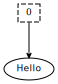

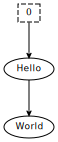

Hello.World

In [22]:
hello = bigraph("Hello")
result = react(add_world, hello)

visualize(hello)
visualize(result)
result

## reactive systems

Beyond applying a single reaction to a single bigraph, we can also run whole systems of reactions in a series of transitions on an original bigraph. In order to do this, we need to define the `system`.

### declaring a reactive system

We can declare the system using `.big` notation:

In [25]:
system = bigraph("""
begin brs
    init hello;
    rules = [
        {add_world}
    ];
end
""")
system

begin brs
    init hello;
    rules = [
        {add_world}
    ];
end

### executing the system

### observing the transitions

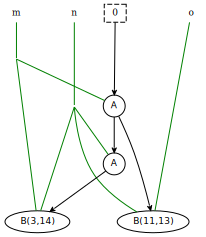

In [24]:
visualize_transition(0, '../out/test/validate') # TODO figure out how to return a svg/png